In [66]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_palette("GnBu_d")
import folium
from folium import plugins
from folium.plugins import HeatMap
from datetime import datetime
from datetime import timedelta
import math
import random 
import timeit
from haversine import haversine

## Defining methods to join bike_data and weather data

In [67]:
def cut_timestamp(timestamp_col):
    return timestamp_col.map(lambda x:int(str(x)[:10]))

def assemble_timestamp_cut(day_frame, time_frame):
    day_clean = day_frame.map(lambda x: x.replace("-", ""))
    hour = time_frame.map(lambda x: x.replace(":", "")[:2])
    return (day_clean + hour).astype("int64")

def join_by_hour(bike_frame, weather_frame, column_name):
    bike_frame["timestamp_cut"] = assemble_timestamp_cut(bike_frame["day"], bike_frame["time"])
    weather_frame["timestamp_cut"] = cut_timestamp(weather_frame["Zeitstempel"])
    
    joined = bike_frame.join(weather_frame[["Wert", "timestamp_cut"]].set_index("timestamp_cut"), on="timestamp_cut")
    joined[column_name] = joined["Wert"]
    
    joined = joined.drop("Wert", axis=1)
    joined = joined.drop("timestamp_cut", axis=1)
    
    return joined

In [68]:
brm_frame = pd.read_csv("resources/bremen.csv")
brm_precipitation = pd.read_csv("resources/bremen_precipitation.csv")
brm_temperature = pd.read_csv("resources/bremen_temperature.csv")
schwarme_precipitation = pd.read_csv("resources/schwarme_precipitation.csv")
bassum_precipitation = pd.read_csv("resources/bassum_precipitation.csv")

#brm_precipitation.info()

Identifying missing values

In [69]:
# loading precipitation data of bremen and mark missing values
brm_precipitation_full = brm_precipitation.join(all_dates_frame.set_index("Zeitstempel"), on="Zeitstempel", how="outer")
brm_precipitation_full = brm_precipitation_full.set_index("Zeitstempel")
brm_precipitation_full = brm_precipitation_full.sort_values("Zeitstempel")
brm_precipitation_full = brm_precipitation_full.reset_index()

#brm_precipitation_full[brm_precipitation_full["Wert"].isnull()]

In [70]:
brm_sub_frame = brm_precipitation_full[(brm_precipitation_full["Zeitstempel"] >= 201902070000) & (brm_precipitation_full["Zeitstempel"] <= 201902080300)]

## Getting data from station of schwarme and station of bassum

In [71]:
# loading precipitation data of schwarme and mark missing values
schwarme_precipitation_full = schwarme_precipitation.join(all_dates_frame.set_index("Zeitstempel"), on="Zeitstempel", how="outer")
schwarme_precipitation_full = schwarme_precipitation_full.set_index("Zeitstempel")
schwarme_precipitation_full = schwarme_precipitation_full.sort_values("Zeitstempel")
schwarme_precipitation_full = schwarme_precipitation_full.reset_index()

bassum_precipitation_full = bassum_precipitation.join(all_dates_frame.set_index("Zeitstempel"), on="Zeitstempel", how="outer")
bassum_precipitation_full = bassum_precipitation_full.set_index("Zeitstempel")
bassum_precipitation_full = bassum_precipitation_full.sort_values("Zeitstempel")
bassum_precipitation_full = bassum_precipitation_full.reset_index()

## Finding the station which has approximately the same precipitation than the station of bremen

In [72]:
schwarme_sub_frame = schwarme_precipitation_full[(schwarme_precipitation_full["Zeitstempel"] >= 201902070000) & (schwarme_precipitation_full["Zeitstempel"] <= 201902080300)]

In [73]:
bassum_sub_frame = bassum_precipitation_full[(bassum_precipitation_full["Zeitstempel"] >= 201902070000) & (bassum_precipitation_full["Zeitstempel"] <= 201902080300)]

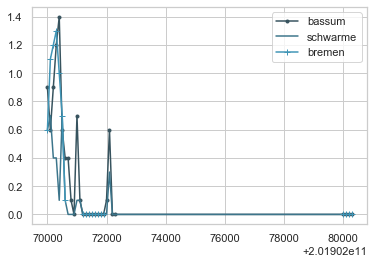

In [74]:
plt.plot(bassum_sub_frame["Zeitstempel"], bassum_sub_frame["Wert"], '.-', label="bassum")
plt.plot(schwarme_sub_frame["Zeitstempel"], schwarme_sub_frame["Wert"], '-', label="schwarme")
plt.plot(brm_sub_frame["Zeitstempel"], brm_sub_frame["Wert"], '+-', label="bremen")

plt.legend()
plt.show()

Since there are missing hours in the weather data, we want to fill these gaps with weater data from the nearest station. 


## combine missing values of brm_precipitation with precipitation values from the city of schwarme

In [75]:
# create a dataframe which contains all dates from 2019-01-20 until 2020-01-20
all_dates_frame = pd.DataFrame(pd.date_range(
    start = datetime.strptime("2019-01-20 00", "%Y-%m-%d %H"), 
    end = datetime.strptime("2020-01-20 00", "%Y-%m-%d %H"),
    freq="1h"), columns=["date"])

all_dates_frame["Zeitstempel"] = all_dates_frame["date"].map(lambda x: int(x.strftime("%Y%m%d%H%M")))
all_dates_frame = all_dates_frame.drop("date", 1)

# loading precipitation data of schwarme and mark missing values
schwarme_precipitation_full = schwarme_precipitation.join(all_dates_frame.set_index("Zeitstempel"), on="Zeitstempel", how="outer")
schwarme_precipitation_full = schwarme_precipitation_full.set_index("Zeitstempel")
schwarme_precipitation_full = schwarme_precipitation_full.sort_values("Zeitstempel")

# loading precipitation data of bremen and mark missing values
brm_precipitation_full = brm_precipitation.join(all_dates_frame.set_index("Zeitstempel"), on="Zeitstempel", how="outer")
brm_precipitation_full = brm_precipitation_full.set_index("Zeitstempel")
brm_precipitation_full = brm_precipitation_full.sort_values("Zeitstempel")

# fill missing values from bremen with values of schwerme
brm_precipitation_full[brm_precipitation_full["Wert"].isnull()] = schwarme_precipitation_full

brm_precipitation_combined = brm_precipitation_full
brm_precipitation_combined = brm_precipitation_combined.reset_index()

In [76]:
brm_frame_precipitation = join_by_hour(brm_frame, brm_precipitation_combined, "precipitation")
brm_frame_precipitation

brm_frame_weather = join_by_hour(brm_frame_precipitation, brm_temperature, "temperature")

#brm_frame_weather.info()

In [77]:
frb_frame = pd.read_csv("resources/freiburg.csv")
frb_precipitation = pd.read_csv("resources/freiburg_precipitation.csv")
frb_temperature = pd.read_csv("resources/freiburg_temperature.csv")

frb_frame_precipitation = join_by_hour(frb_frame, frb_precipitation, "precipitation")
frb_frame_weather = join_by_hour(frb_frame_precipitation, frb_temperature, "temperature")

#frb_frame_weather.info()

In [95]:
BRM = brm_frame_weather
FRB = frb_frame_weather

In [96]:
BRM["trip_duration"] = BRM["trip_duration"].astype(str).str.extract("days (.*?)\.")
FRB["trip_duration"] = FRB["trip_duration"].astype(str).str.extract("days (.*?)\.")

To work with the duration of the Trips we need to convert them to a useful type:

In [97]:
BRM["trip_duration"] = BRM["trip_duration"].apply(pd.Timedelta)
FRB["trip_duration"] = FRB["trip_duration"].apply(pd.Timedelta)

After the convertion we can sum the time daily driven:

In [98]:
BRM_daily_driven = BRM.groupby("day").agg({"trip_duration":"sum"})
FRB_daily_driven = FRB.groupby("day").agg({"trip_duration":"sum"})

For a more detailed aggregation we add a daytime to the variables, so we can calculate time driven by daytime. This also allows a better mapping of how weather effects demand.

In [99]:
BRM["daytime"] = "null"
FRB["daytime"] = "null"

Define Daytimes: Morning: 6 - 11 | Noon: 11 - 16 | Evening: 16 - 21 | Night: 21 - 6

In [100]:
BRM_morning = BRM[(BRM["time"] > "06:00:00") & (BRM["time"] <= "11:00:00")] #saving rows where time is in defined range to a new df
BRM_noon = BRM[(BRM["time"] > "11:00:00") & (BRM["time"] <= "16:00:00")]
BRM_evening = BRM[(BRM["time"] > "16:00:00") & (BRM["time"] <= "21:00:00")]
BRM_night = BRM[(BRM["time"] > "21:00:00")] + BRM[(BRM["time"] <= "06:00:00")]

In [101]:
FRB_morning = FRB[(FRB["time"] > "06:00:00") & (FRB["time"] <= "11:00:00")]
FRB_noon = FRB[(FRB["time"] > "11:00:00") & (FRB["time"] <= "16:00:00")]
FRB_evening = FRB[(FRB["time"] > "16:00:00") & (FRB["time"] <= "21:00:00")]
FRB_night = FRB[(FRB["time"] > "21:00:00")] + FRB[(FRB["time"] <= "06:00:00")]

adding corresponding values to column:

In [102]:
for i in BRM_morning.index: # using indexes from lists above to cycle through the whole data
   BRM.at[i , "daytime"] = 0 # morning refers to 0
for i in BRM_noon.index:
   BRM.at[i , "daytime"] = 1 # noon -> 1
for i in BRM_evening.index:
   BRM.at[i , "daytime"] = 2 # evening -> 2
for i in BRM_night.index:
   BRM.at[i , "daytime"] = 3 # night -> 3

In [103]:
for i in FRB_morning.index:
   FRB.at[i , "daytime"] = 0
for i in FRB_noon.index:
   FRB.at[i , "daytime"] = 1
for i in FRB_evening.index:
   FRB.at[i , "daytime"] = 2
for i in FRB_night.index:
   FRB.at[i , "daytime"] = 3

Summarizing data over day and daytime via aggregation of the trip durations taken.

In [104]:
BRM_daytime_driven = BRM.groupby(["day","daytime"]).agg({"trip_duration":"sum"})
BRM_daytime_driven["trip_duration"] = BRM_daytime_driven["trip_duration"].astype(str).str.extract("days (.*?)\.")

In [105]:
FRB_daytime_driven = FRB.groupby(["day","daytime"]).agg({"trip_duration":"sum"})
FRB_daytime_driven["trip_duration"] = FRB_daytime_driven["trip_duration"].astype(str).str.extract("days (.*?)\.")

In [106]:
# Anzeige von dem ganzen gedöns das ich ausgerechnet hab und ein Auschnitt von einem Tag aus Freiburg zur Überprüfung:
#print(BRM_daytime_driven)# falls jemand weiss wie man daytime als Spalten bekommt sagt bescheid 😄 (hab 1std versucht das hinzubekomme dann wars mir zu blöd 🤣)
#print(FRB_daytime_driven)
#print(FRB[FRB["day"] == "2019-05-07"])

In [107]:
BRM["hour"] = BRM["time"].str[:-6]

In [125]:
BRM_hourly_driven = BRM.groupby(["day","hour"]).agg({"trip_duration":"sum","precipitation":"mean","temperature":"mean"})

In [126]:
BRM_hourly_driven

trip_duration  precipitation  temperature
day        hour                                          
2019-01-20 00        00:21:00            0.0         -3.8
           01        00:34:00            0.0         -3.2
           02        01:51:00            0.0         -3.6
           03        00:18:00            0.0         -4.5
           05        01:10:00            0.0         -4.9
...                       ...            ...          ...
2020-01-20 19        06:24:00            0.0          4.4
           20        05:20:00            0.0          4.7
           21        01:47:00            0.0          4.7
           22        02:28:00            0.0          4.7
           23        00:23:00            0.0          4.5

[8409 rows x 3 columns]

In [127]:
BRM

,day,time,b_number,city,trip_duration,orig_lat,orig_lng,dest_lat,dest_lng,precipitation,temperature,daytime,hour
0,2019-04-21,17:34:00,20507,bremen,00:13:00,53.078923,8.884911,53.078711,8.899906,0.0,21.2,2,17
1,2019-05-23,15:33:00,20507,bremen,00:07:00,53.078923,8.884911,53.078004,8.876828,0.0,20.4,1,15
2,2019-06-14,22:30:00,20507,bremen,00:08:00,53.078923,8.884911,53.074731,8.876003,0.0,19.6,3,22
3,2019-06-16,10:00:00,20507,bremen,02:02:00,53.074731,8.876003,53.078923,8.884911,0.0,21.6,0,10
4,2019-06-16,12:55:00,20507,bremen,02:23:00,53.078923,8.884911,53.076236,8.891322,0.0,22.5,1,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
157571,2019-11-17,16:37:00,20999,bremen,00:08:00,53.072835,8.814104,53.072084,8.828756,0.0,4.8,2,16
157572,2019-11-17,18:39:00,20999,bremen,00:05:00,53.072071,8.828776,53.070533,8.821335,0.0,4.9,2,18
157573,2019-11-18,09:23:00,20999,bremen,00:09:00,53.070369,8.821749,53.079360,8.813848,0.0,5.8,0,09
157574,2019-11-19,15:35:00,20999,bremen,00:43:00,53.079591,8.813925,53.145093,8.910599,0.0,7.0,1,15
